In [409]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import root 
import scipy.linalg as la
from scipy.interpolate import UnivariateSpline as spline
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta as rd

In [348]:
# Import and initialize data
folder_path = os.getcwd()

file_path = os.path.join(folder_path, '10bonds.csv')

data_orig = pd.read_csv(file_path)

days = ['2021/01/18', '2021/01/19', '2021/01/20', '2021/01/21', '2021/01/22',
        '2021/01/25', '2021/01/26', '2021/01/27', '2021/01/28', '2021/01/29']


In [349]:
# Data cleaning
data = {}
for d in days:
    data_d = {"ISIN" : list(data_orig["ISIN"]),
              "clean_price": [float(t) for t in list(data_orig[d])],
              "coupon": [float(a.split('%')[0]) for a in list(data_orig["coupon"])],
              "issue_date" : [datetime.strptime(t, '%Y/%m/%d') for t in list(data_orig['issue_date'])], 
              "maturity_date" : [datetime.strptime(t, '%Y/%m/%d') for t in list(data_orig['maturity_date'])] 
             }
    data[d] = pd.DataFrame(data_d)


In [350]:
# Yield to maturity

## Given specific time date of clean price collection, 
##   list all dates of issuing coupons in the future, also the last payment, time to maturity

def coupon_dates(data,d):
    
    data_d = data[d]
    coupon_dates = []
    now = datetime.strptime(d, '%Y/%m/%d')
    period = rd.relativedelta(months = 6)               #coupon period
    last_coupon = []
    time_to_maturity = []
    
    for i in range(10):                                 #loop over 10 bonds
        issue = data_d.issue_date[i]                    #issue date of bond i
        maturity = data_d.maturity_date[i]              #maturity date of bond i
        to_coupon = maturity - now                      #time to maturity, or coupon
        time_to_maturity.append(to_coupon)
        coupon_day = maturity            #last coupon day, maturity date
        to_issue=[]
        
        while to_coupon.days > 0:   #loop over all not yet issued coupon
            to_issue.append(coupon_day)
            coupon_day = coupon_day - period
            to_coupon = coupon_day - now
            
        coupon_dates.append(to_issue)
        last_coupon.append(coupon_day)
        
            
    return coupon_dates, last_coupon, time_to_maturity


In [366]:
## Calculate the dirty price

def dirty_price(data,d):
    
    data_d = data[d]
    now = datetime.strptime(d, '%Y/%m/%d')
    dirty_price = []
    
    for i in range(10):
        clean_price = data_d.clean_price[i]
        next_coupon = data_d.future_coupons[i][-1]
        last_coupon = data_d.last_coupon[i]
        period = (next_coupon - last_coupon).days
        coupon_rate = data_d.coupon[i]
        n = (now-last_coupon).days

        acc_interest = coupon_rate*n/365
        dirty = clean_price + acc_interest

        dirty_price.append(dirty)
    
    return dirty_price
        
    

In [367]:
## Calculate yield to maturity

def ytm(data,d):
    
    data_d = data[d]
    dates = data_d.maturity_date
    price = data_d.dirty_price
    future = data_d.future_coupons
    coupon = data_d.coupon/2
    T = data_d.time_to_maturity
    now = datetime.strptime("2021/02/01", '%Y/%m/%d')
    
    years = [0]+[(k - now).days/365 for k in dates]
    ytm = [0]
    
    for i in range(10):
        time = np.sort([(k - now).days/365*2 for k in future[i]])
        P = price[i]
        pi = np.array([coupon[i]]*(len(time)-1)+[coupon[i]+100])
        def y(r):
            return np.dot(pi, 1/(1+r/2)**time)-P
        ytm.append(root(y,0).x[0])
    
    ytm_rate = pd.DataFrame({"rate": ytm,
                       "time": years})
    
    return ytm_rate
    
    
    

In [368]:
## Calculate spot rate

def spot(data,d):
    data_d = data[d]
    dates = data_d.maturity_date
    price = data_d.dirty_price
    future = data_d.future_coupons
    coupon = data_d.coupon/2
    T = data_d.time_to_maturity
    now = datetime.strptime("2021/02/01", '%Y/%m/%d')
    
    years = [0]+[(k - now).days/365 for k in dates]
    spot = [0]


    # 2021-08-01
    time = np.sort([(k - now).days/365*2 for k in future[0]])
    P = price[0]
    p0 = np.array([coupon[0]]*(len(time)-1)+[coupon[0]+100])
    def y(r):
        return np.dot(p0, 1/(1+r/2)**time)-P
    spot.append(root(y,0).x[0])
    
    # 2022-02-02 to 2023-02-01

    for i in [1,2,3]:
        time = np.sort([(k - now).days/365*2 for k in future[i]])
        P = price[i]
        pi = np.array([coupon[i]]*(len(time)-1)+[coupon[i]+100])
        def y(r):
            return (np.dot(pi, 1/(1+np.array(spot +[r])/2)**time)-P)
        spot.append(root(y,0).x[0])
        
    # 2023-06-01
    fnc = spline(years[:5],spot)
    time = np.sort([(k - now).days/365*2 for k in future[4]])
    rates4 = fnc(time[:-1])
    p4 = np.array([coupon[4]]*(len(time)-1)+[coupon[4]+100])
    P = price[4]
    def y(r):
        rates = np.array(list(rates4)+[r])
        return (np.dot(p4, 1/(1+rates/2)**time)-P)
    spot.append(root(y,0).x[0])
    
    # 2024-03-01
    fnc = spline(years[:6],spot)
    time = np.sort([(k - now).days/365*2 for k in future[5]])
    rates5 = fnc(time[:-2])
    p5 = np.array([coupon[5]]*(len(time)-1)+[coupon[5]+100])
    P = price[5]
    def y(r):
        rates = np.array(list(rates5)+ [(r+rates5[-1])/2,r])
        return (np.dot(p5, 1/(1+rates/2)**time)-P)
    spot.append(root(y,0).x[0])
    
    # 2024-09-01 to 2026-03-01
    
    for i in [6,7,8,9]:
        fnc = spline(years[:(i+1)],spot)
        time = np.sort([(k - now).days/365*2 for k in future[i]])
        ratesi = fnc(time[:-1])
        pi = np.array([coupon[i]]*(len(time)-1)+[coupon[i]+100])
        P = price[i]
        def y(r):
            rates = np.array(list(ratesi)+[r])
            return (np.dot(pi, 1/(1+rates/2)**time)-P)
        spot.append(root(y,0).x[0])
    
    spot_rate = pd.DataFrame({"rate": spot,
                       "time": years})
    
    return spot_rate
    
    


In [371]:
# Calculate forward rate

def forward(data,d):
    
    spot_rate = spot_data[d].rate
    time_rate = spot_data[d].time
    spot_line = spline(time_rate, spot_rate)
    
    years = [1,2,3,4,5]
    spot = list(spot_line(years))
    time = [1,2,3,4]
    forward = []

    for i in range(4):
        f = (spot[i+1]+1)**(i+2)/(spot[i]+1)**(i+1)-1
        forward.append(f)

    forward_rate = pd.DataFrame({"rate": forward,
                       "time": time})
    return forward_rate
    


In [372]:
# Do the functions

spot_data = {}
ytm_data = {}
forward_data = {}
for d in days:
    data[d]["future_coupons"],data[d]["last_coupon"], data[d]["time_to_maturity"] = coupon_dates(data,d)
    data[d]["dirty_price"] = dirty_price(data,d)
    spot_data[d] = spot(data,d)
    ytm_data[d] = ytm(data,d)
    forward_data[d] = forward(data,d)


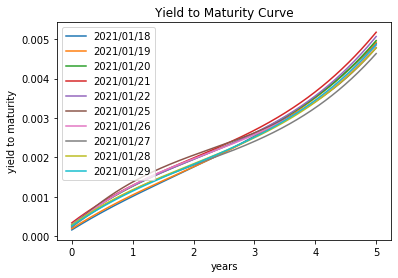

In [373]:
# Plot the yield curves

for d in days:
    
    ytm = ytm_data[d].rate
    years = ytm_data[d].time
    ytm_line = spline(years,ytm)
    new_years = np.linspace(0, 5, num=1000, endpoint=True)
    new_ytm = ytm_line(new_years)
    plt.plot(new_years, new_ytm, label = d)
    
plt.legend(loc='best')
plt.xlabel("years")
plt.ylabel("yield to maturity")
plt.title("Yield to Maturity Curve")

plt.savefig('YTM.png')

plt.show()

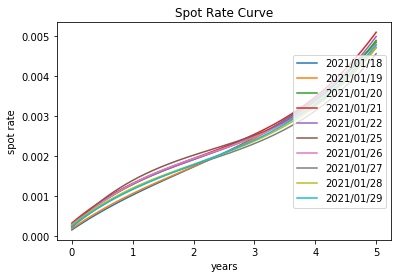

In [374]:
# Plot the spot rate curves

for d in days:
    spot = spot_data[d].rate
    years = spot_data[d].time
    spot_line = spline(years,spot)
    new_years = np.linspace(0, 5, num=1000, endpoint=True)
    new_spot = spot_line(new_years)
    plt.plot(new_years, new_spot, label = d)
    
plt.legend(loc='right')
plt.xlabel("years")
plt.ylabel("spot rate")
plt.title("Spot Rate Curve")

plt.savefig('Spot.png')

plt.show()



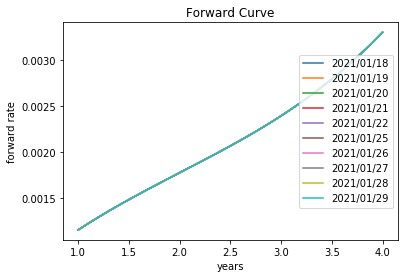

In [375]:
# Plot the forward rate curves

for d in days:
    forward = forward_data[d].rate
    years = forward_data[d].time
    forward_line = spline(years,forward)
    new_years = np.linspace(1,4, num=1000, endpoint=True)
    new_forward = spot_line(new_years)
    plt.plot(new_years, new_forward, label = d)
    
plt.legend(loc='right')
plt.xlabel("years")
plt.ylabel("forward rate")
plt.title("Forward Curve")

plt.savefig('Forward.png')

plt.show()

In [404]:
# Calculating Covariance matrices

def cov_matrix(rate_data, days):
    

    if len(rate_data[days[0]].rate) < 5:
        time = [1,2,3,4]
    else:
        time = [1,2,3,4,5]
        
    R = []
    
    for d in days:
        rate_raw = rate_data[d].rate
        time_raw = rate_data[d].time
        rate_curve = spline(time_raw, rate_raw)
        rate = rate_curve(time)
        R.append(rate)
    
    R = np.array(R).T
    
    X = []
    for i in range(np.shape(R)[0]):
        r = R[i,:]
        xi = []
        for j in range(np.shape(R)[1]-1):
            xij = np.log(r[j+1]/r[j])
            xi.append(xij)
        X.append(xi)
    
    X = np.array(X)

    mat = np.cov(X)
    
    return mat


In [414]:
# Use the function
ytm_cov = cov_matrix(ytm_data,days)
forward_cov = cov_matrix(forward_data,days)
print(np.matrix.round(forward_cov,5))
print(np.matrix.round(ytm_cov,5))

[[ 1.75e-03  4.00e-05 -5.40e-04  4.00e-05]
 [ 4.00e-05  1.32e-03  1.56e-03  8.90e-04]
 [-5.40e-04  1.56e-03  2.32e-03  1.61e-03]
 [ 4.00e-05  8.90e-04  1.61e-03  1.71e-03]]
[[0.00719 0.00453 0.00201 0.00045 0.00021]
 [0.00453 0.00304 0.00155 0.00056 0.00032]
 [0.00201 0.00155 0.00118 0.00089 0.00074]
 [0.00045 0.00056 0.00089 0.0011  0.00107]
 [0.00021 0.00032 0.00074 0.00107 0.00113]]


In [424]:
# Calculating eigenvalues and eigenvectors of covariance matrices
print(la.eig(ytm_cov)[0])
print(np.matrix.round(la.eig(ytm_cov)[1],3))
print(la.eig(forward_cov)[0])
print(np.matrix.round(la.eig(forward_cov)[1],3))

[1.08911405e-02+0.j 2.54045118e-03+0.j 1.96994215e-04+0.j
 8.21955876e-06+0.j 1.95844173e-08+0.j]
[[-0.801 -0.251 -0.439 -0.313  0.064]
 [-0.524 -0.003  0.463  0.622 -0.352]
 [-0.263  0.381  0.526 -0.229  0.676]
 [-0.098  0.626  0.07  -0.475 -0.607]
 [-0.065  0.632 -0.558  0.487  0.218]]


[4.64894692e-03+0.j 1.81469931e-03+0.j 4.22367515e-07+0.j
 6.27870674e-04+0.j]
[[ 0.119  0.962  0.236 -0.07 ]
 [-0.467  0.155 -0.585 -0.644]
 [-0.702 -0.093  0.692 -0.141]
 [-0.524  0.205 -0.351  0.748]]


5

array([0.00100893, 0.00104498, 0.00126563, 0.00128779, 0.0012709 ,
       0.0013727 , 0.00128839, 0.00116559, 0.00117463, 0.00114211])